# 21. RNN의 기초 원리를 배워봅시다.

* 서울의 주간평균기온 데이터를 이용하여 RNN 모델을 구현해 봅시다.

## 1.환경 및 데이터 준비

### Import Packages

In [ ]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error

### Data Loading

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/temperature.csv')
data.head(10)

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857
5,2010,6,-1.800000
6,2010,7,-0.314286
7,2010,8,-2.142857
8,2010,9,4.400000
9,2010,10,7.057143


In [ ]:
data.tail()

,year,week,AvgTemp
260,2014,49,8.100000
261,2014,50,-4.357143
262,2014,51,-2.142857
263,2014,52,-5.542857
264,2014,53,-0.728571


## 2.데이터 이해

### 탐색하기

온도의 흐름(trend)을 살펴봅시다.

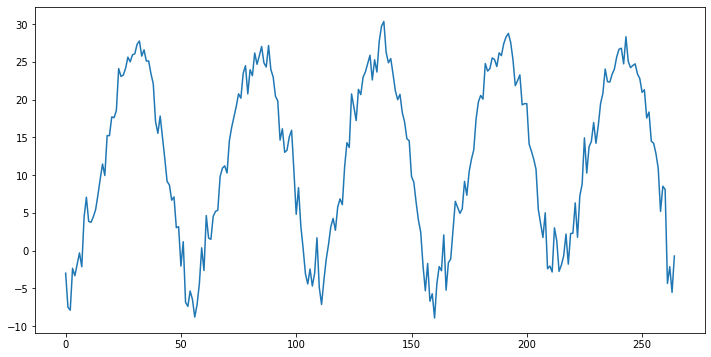

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.AvgTemp)
plt.show()

##3.데이터 준비

### 불필요한 데이터 정리 

In [ ]:
data = data.drop(['year','week'], axis=1)
data.head()

,AvgTemp
0,-3.000000
1,-7.500000
2,-7.900000
3,-2.357143
4,-3.342857


### Scaling



In [ ]:
# 필요한 함수 로딩
from sklearn.preprocessing import MinMaxScaler

# 함수 선언
scaler = MinMaxScaler()

# 함수 적용하기
data_sc = scaler.fit_transform(data)

In [ ]:
# 스케일링한 후에 원래대로 다시 돌려 놓기 위해서는, 아래의 정보들이 필요합니다.
print(scaler.data_max_, scaler.data_min_, scaler.data_range_)

[30.34285714] [-8.93333333] [39.27619047]


In [ ]:
# 스케일링한 데이터를 살펴봅시다.
print(data[:5].values)
print('-------')
print(data_sc[:5])

[[-3.        ]
 [-7.5       ]
 [-7.9       ]
 [-2.35714286]
 [-3.34285714]]
-------
[[0.15106693]
 [0.0364937 ]
 [0.02630941]
 [0.16743453]
 [0.14233754]]


## 4.Sequence 데이터 구조로 만들기

다음 주의 평균 기온을 예측하기 위해서 과거 몇주간의 정보가 유의미할까요?

In [ ]:
data_sc.shape

(265, 1)

In [ ]:
data = data.values

In [ ]:
# 여기에 의미있는 기간(timestep을 지정해 봅시다.)
timestep= 20

# x의 데이터 구조를 3차원으로 만들어줘야 합니다.
x = np.array([data_sc[i : i + timestep] for i in range(len(data_sc) - timestep)])
y = np.array([data_sc[i + timestep] for i in range(len(data_sc) - timestep)])

x_train, x_val, x_test = x[:160], x[160:200], x[200:]
y_train, y_val, y_test = y[:160], y[160:200], y[200:]

print(x.shape, y.shape)
print('-------------------------------')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(245, 20, 1) (245, 1)
-------------------------------
(160, 20, 1) (160, 1)
(40, 20, 1) (40, 1)
(45, 20, 1) (45, 1)


데이터의 구조 : [n, timestep, feature수]

In [ ]:
print(x[0])
print('--------------')
print(y[0])


[[0.15106693]
 [0.0364937 ]
 [0.02630941]
 [0.16743453]
 [0.14233754]
 [0.18161979]
 [0.21944714]
 [0.1728904 ]
 [0.33947624]
 [0.407129  ]
 [0.3256547 ]
 [0.32274491]
 [0.34093113]
 [0.36530068]
 [0.41440349]
 [0.46896217]
 [0.51915616]
 [0.48060136]
 [0.61517944]
 [0.61481571]]
--------------
[0.67810378]


In [ ]:
print(x[1])
print('--------------')
print(y[1])

[[0.0364937 ]
 [0.02630941]
 [0.16743453]
 [0.14233754]
 [0.18161979]
 [0.21944714]
 [0.1728904 ]
 [0.33947624]
 [0.407129  ]
 [0.3256547 ]
 [0.32274491]
 [0.34093113]
 [0.36530068]
 [0.41440349]
 [0.46896217]
 [0.51915616]
 [0.48060136]
 [0.61517944]
 [0.61481571]
 [0.67810378]]
--------------
[0.67555771]


## 5.RNN 모델링

### 필요한 함수

In [ ]:
from sklearn.metrics import mean_squared_error

def mse_real(y_test, y_pred, max, min, squared = True):
    # 실제값 변환 
    y_test_r = y_test * (max - min) + min
    y_pred_r = y_pred * (max - min) + min
    if squared == 1 :
        return(mean_squared_error(y_test_r, y_pred_r))
    else :    
        return(mean_squared_error(y_test_r, y_pred_r, squared = False))

### [실습]무작정 RNN 모델링 수행해보기

아래 코드를 완성해 봅시다.

In [ ]:
np.random.seed(2021)
tf.random.set_seed(2021)

# 1.세션클리어
keras.backend.clear_session()

# 2.Sequential 모델 선언하기
model = keras.models.Sequential()

# 3. 레이어 쌓기 SimpleRNN의 default activation은 'tanh' 입니다.
# input_shape = [timestep, feature수]
# simplernn의 노드는 4개로 작성해 봅시다.
model.add(keras.layers.SimpleRNN(4, input_shape=[20, 1]) )
model.add(keras.layers.Dense(1, activation='tanh'))

# compile
model.compile(loss='mse', optimizer='adam')

# 학습
history = model.fit(x, y, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
8/8 [==============================] - 1s 71ms/step - loss: 0.3056 - val_loss: 0.2932
Epoch 2/30
8/8 [==============================] - 0s 8ms/step - loss: 0.2512 - val_loss: 0.2480
Epoch 3/30
8/8 [==============================] - 0s 9ms/step - loss: 0.2295 - val_loss: 0.2065
Epoch 4/30
8/8 [==============================] - 0s 8ms/step - loss: 0.1841 - val_loss: 0.1707
Epoch 5/30
8/8 [==============================] - 0s 8ms/step - loss: 0.1524 - val_loss: 0.1399
Epoch 6/30
8/8 [==============================] - 0s 9ms/step - loss: 0.1164 - val_loss: 0.1147
Epoch 7/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0949 - val_loss: 0.0946
Epoch 8/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0824 - val_loss: 0.0793
Epoch 9/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0674 - val_loss: 0.0678
Epoch 10/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0583 - val_loss: 0.0593
Epoch 11/30
8/8 [=====================

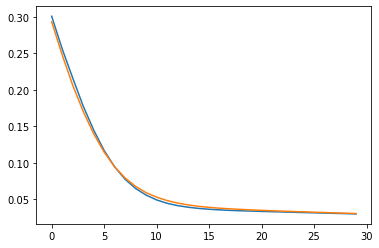

In [ ]:
# 학습 곡선을 그려봅시다.
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
# 예측
y_pred = model.predict(x_test)

In [ ]:
# 평가1
mean_squared_error(y_test, y_pred, squared=False)

0.17183957575218983

In [ ]:
# 평가2
mse_real(y_test, y_pred, scaler.data_max_[0], scaler.data_min_[0], squared=0)


6.749203931766405

### 선형회귀모형

In [ ]:
np.random.seed(2021)
tf.random.set_seed(2021)

# 세션클리어
keras.backend.clear_session()

# Sequential 모델 선언 + layer 추가하기(한꺼번에)
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[timestep, 1]), #왜 flatten을 사용했을까요?
    keras.layers.Dense(1)
])

model1.compile(loss="mse", optimizer=keras.optimizers.Adam(lr = 0.005))
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
5/5 [==============================] - 1s 36ms/step - loss: 0.0297 - val_loss: 0.0304
Epoch 2/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0295 - val_loss: 0.0302
Epoch 3/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0292 - val_loss: 0.0300
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0289 - val_loss: 0.0298
Epoch 5/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0287 - val_loss: 0.0295
Epoch 6/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0284 - val_loss: 0.0293
Epoch 7/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0281 - val_loss: 0.0291
Epoch 8/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0279 - val_loss: 0.0289
Epoch 9/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0276 - val_loss: 0.0287
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0274 - val_loss: 0.0285
Epoch 11/20
5/5 [============

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


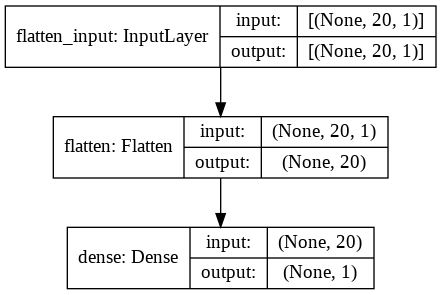

In [ ]:
plot_model(model1,show_shapes=True)

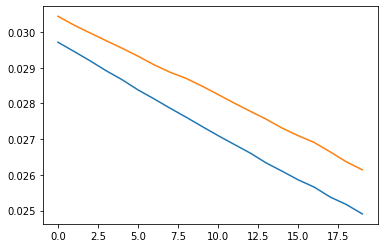

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
# 예측
y_pred = model1.predict(x_test)

In [ ]:
# 평가
mse_real(y_test, y_pred, scaler.data_max_[0], scaler.data_min_[0], squared=0)


11.091497876351415

### Simple RNN

In [ ]:
np.random.seed(2021)
tf.random.set_seed(2021)

# 세션클리어
keras.backend.clear_session()

# Sequential 모델 선언 + layer 추가하기(한꺼번에)
model = keras.models.Sequential([
    keras.layers.SimpleRNN(10, input_shape=[timestep,1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.005))
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
5/5 [==============================] - 1s 56ms/step - loss: 0.0753 - val_loss: 0.0923
Epoch 2/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0430 - val_loss: 0.0317
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0281 - val_loss: 0.0101
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0104 - val_loss: 0.0120
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0151 - val_loss: 0.0074
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 7/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 8/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 9/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0066 - val_loss: 0.0048
Epoch 11/20
5/5 [============

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


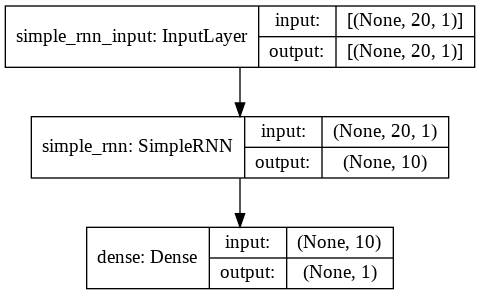

In [ ]:
plot_model(model, show_shapes=True)

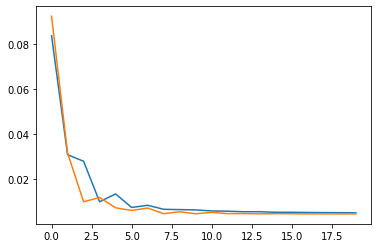

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
# 예측
y_pred = model.predict(x_test)

In [ ]:
# 평가
mse_real(y_test, y_pred, scaler.data_max_[0], scaler.data_min_[0], squared=0)

2.922705663687864

**22번 실습파일을 열어서 과제1, 2, 3을 수행합니다.**

### Deep RNNs

In [ ]:
np.random.seed(2021)
tf.random.set_seed(2021)

# 세션클리어
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, input_shape=[timestep, 1], return_sequences=True),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.005))
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
5/5 [==============================] - 2s 129ms/step - loss: 0.3936 - val_loss: 0.2079
Epoch 2/20
5/5 [==============================] - 0s 16ms/step - loss: 0.1048 - val_loss: 0.0592
Epoch 3/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0524 - val_loss: 0.0509
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0282 - val_loss: 0.0214
Epoch 5/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0142 - val_loss: 0.0118
Epoch 6/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0114 - val_loss: 0.0080
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 8/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 9/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 10/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 11/20
5/5 [===========

* (옵션) 특정 함수들을 불러오도록 하여 코드를 간소화해 봅시다.

In [ ]:
from keras.backend import clear_session()
from 
from


SyntaxError: ignored

In [ ]:
# 위 모델선언 부분을 간소화 해 봅시다.




In [ ]:
model.summary()

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
# 예측 및 평가
y_pred = model.predict(x_test)

In [ ]:
# 평가
mse_real(y_test, y_pred, scaler.data_max_[0], scaler.data_min_[0], squared=0)

**22번 실습파일을 열어서 과제4를 수행합니다.**

## 6.LSTM 모델링

In [ ]:
np.random.seed(2021)
tf.random.set_seed(2021)

model = keras.models.Sequential([
    keras.layers.LSTM(32, input_shape = [timestep,1], return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.005))
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

In [ ]:
model.summary()

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
# 예측 및 평가
y_pred = model.predict(x_test)

In [ ]:
# 평가
mse_real(y_test, y_pred, scaler.data_max_[0], scaler.data_min_[0], squared=0)

## 7.GRU 모델링

In [ ]:
np.random.seed(2021)
tf.random.set_seed(2021)

model = keras.models.Sequential([
    keras.layers.GRU(32, input_shape = [timestep,1], return_sequences=True),
    keras.layers.GRU(32),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.005))
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

In [ ]:
model.summary()

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
# 예측 및 평가
y_pred = model.predict(x_test)

In [ ]:
# 평가
mse_real(y_test, y_pred, scaler.data_max_[0], scaler.data_min_[0], squared=0)